<a href="https://colab.research.google.com/github/langdonholmes/lexical_analysis/blob/main/ICNALE_lexical_finetune_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning BERT
We want to predict the lexical proficiency of the author of a text.

We start with a pre-trained BERT language model and feed it labelled examples.

## Requirements
First step is to install some packages to the Colab runtime using %%writefile magic.

In [ ]:
%%writefile requirements.txt
transformers
datasets

Writing requirements.txt


In [ ]:
!pip install -q -r requirements.txt

     |████████████████████████████████| 3.8 MB 4.4 MB/s 
     |████████████████████████████████| 325 kB 56.0 MB/s 
     |████████████████████████████████| 67 kB 3.3 MB/s 
     |████████████████████████████████| 895 kB 49.2 MB/s 
     |████████████████████████████████| 6.5 MB 30.9 MB/s 
     |████████████████████████████████| 596 kB 63.2 MB/s 
     |████████████████████████████████| 212 kB 52.3 MB/s 
     |████████████████████████████████| 1.1 MB 49.0 MB/s 
     |████████████████████████████████| 134 kB 60.8 MB/s 
     |████████████████████████████████| 127 kB 68.2 MB/s 
     |████████████████████████████████| 271 kB 61.0 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 
     |████████████████████████████████| 144 kB 55.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which i

## Modules

In [ ]:
# Files
import os

# Feedback
from tqdm import tqdm # progress bars
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Digits and Strings
import numpy as np
import pandas as pd
import re # regex

# Util
from itertools import product # Cartesian product

# Huggingface
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset, DatasetDict
from transformers import TrainingArguments, Trainer

_model = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(_model, use_fast=True)

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# PyTorch
import torch
if not torch.cuda.is_available():
  print('Time is a limited resource. Find a gpu.')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Data
There are a lot of options to experiment with here, so let's manage them with a class.

In [ ]:
class icnale_data:
  '''
  Takes a pandas dataframe and optionally prepocesses it a bit.
  _dataset.make() will return a Huggingface Dataset object.
  Details are ICNALE specific, of course.
  '''
  def __init__(self,
               df,
               scale_y=True,
               check_seq_lengths=False):
     
    self.check_seq_lengths=check_seq_lengths

    df['label'] = df['VST'] # Huggingface calls it a label

    if scale_y: # Scale VST to floating point between -1 and 1
      self.scaler = MinMaxScaler(feature_range=(-1, 1))
      df['label'] = self.scaler.fit_transform(df[['label']])

    self.df = df[['label', 'text']]

  def tokenize(self, batch):
    '''
    Turns text into a series of numbers that BERT can understand.
    '''
    return tokenizer(batch['text'],
                    padding="max_length",
                    truncation=True,
                    max_length=tokenizer.max_model_input_sizes[_model],
                    return_overflowing_tokens=self.check_seq_lengths)
    
  def make(self):
    '''
    Let's manage our data with Huggingface's Dataset class, which is basically
    just a Python dictionary.
    '''     
    dataset = Dataset.from_pandas(self.df.reset_index(drop=True))
    dataset = dataset.map(self.tokenize, batched=True, batch_size=1)
    dataset = dataset.remove_columns('text')

    # this is just to check whether any texts have been truncated by tokenizer.
    if self.check_seq_lengths:
      truncated = [tensor for tensor in dataset['overflowing_tokens']
                   if len(tensor) > 0]
      print(f'{len(truncated)} documents have been truncated in the dataset.')

    # some pretrained models do not use token_type_ids
    columns = ['input_ids', 'token_type_ids', 'attention_mask', 'label']
    columns = list(set(columns).intersection(dataset.column_names))
    dataset.set_format(type='torch',
                      columns=columns,
                      device='cuda')
    return dataset

both_prompts_but_no_test = '/content/drive/MyDrive/data/icnale_bert_lexical/all_icnale_train.csv'
test_smk_path = '/content/drive/MyDrive/data/icnale_bert_lexical/smk_test.csv'

train_df = pd.read_csv(both_prompts_but_no_test)
test_df = pd.read_csv(test_smk_path)

datadict = DatasetDict({
            'train': icnale_data(train_df).make(),
            'test': icnale_data(test_df).make()})

  0%|          | 0/4680 [00:00<?, ?ba/s]

  0%|          | 0/520 [00:00<?, ?ba/s]

## Hyperparameter Search Configuration
We follow Devlin et al.'s recommendations quite closely here. After some experimentation with freezing layers and other approaches, we found that the original BERT paper made appropriate suggestions for this dataset and task.

In [ ]:
batch_size = 16 # apriori selected due to GPU memory limitations.
freeze = False # If true, do not back propogate to some of BERT's layers
freeze_to = 8 # The last layer to freeze

def model_init():
  '''
  initialize model with a pooling layer and linear layer
  when num_labels = 1, does regression (> 1 is classification)
  optionally freezes some of BERT's layers with regex matching
  '''

  model = BertForSequenceClassification.from_pretrained(_model,
                                                        num_labels=1)
  if freeze:
    pattern = re.compile(f'bert.(embeddings|encoder.layer.[0-{freeze_to}]\.)')
    for name, param in model.named_parameters():
      if pattern.match(name):
        param.requires_grad = False

  return model

def compute_metrics(pred):
    return {'r2': r2_score(pred.label_ids, pred.predictions)}

args = TrainingArguments(
    output_dir='/content/drive/MyDrive/data/icnale_bert_lexical/temp',
    evaluation_strategy='epoch',
    learning_rate=5e-05, # Finetuned
    weight_decay=0.01, # Devlin et al. suggested
    num_train_epochs=2, # Finetuned
    seed=1, # apriori
    logging_strategy='epoch',
    save_strategy='no',
    fp16=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=False,
)

trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=datadict['train'],
    eval_dataset=datadict['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

https://huggingface.co/ber

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
creating metadata file for /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'c

## Hyperparamter Search Execution
The following hyperparameter search takes a few hours. You probably want to skip the next two cells.

In [ ]:
# in case the process gets interrupted, it would be nice to keep some results
import json
import logging
logfile = '/content/drive/MyDrive/data/icnale_bert_lexical/temp/hp_bert.log'
logging.basicConfig(level=logging.INFO,
                    filename=logfile,
                    format='%(asctime)s -- %(message)s')

param_grid = {
    "learning_rate": [2e-5, 3e-5, 5e-5], # Range suggested by Devlin et al.
    "num_train_epochs": [2, 3, 4] # Range suggested by Devlin et al.
}

logging.info('New Hyperparameter Search, minmaxscaler -1 to 1')
logging.info(json.dumps(param_grid))

# Since we have 2 settings with 3 values each, we will finetune 9 times
cartesian_product = [dict(zip(param_grid.keys(), values)) for 
                     values in product(*param_grid.values())]

for i, params in enumerate(cartesian_product):
  for k, v in params.items():
    setattr(trainer.args, k, v)

  start = time.time()
  trainer.train()
  time_elapsed = time.time() - start

  preds = trainer.predict(datadict['valid'])
  r2 = r2_score(preds.label_ids, preds.predictions)

  print(', '.join([f'{k}: {v}' for k, v in params.items()]), end=' ')
  print(f'--> R-squared: {r2:.3f}')
  print(f'Time elapsed: {time_elapsed:.0f} seconds')

  params['trial'] = i
  params['score'] = r2
  params['seconds'] = time_elapsed

  logging.info(json.dumps(params))

In [ ]:
with open(logfile) as f:
    param_results = [json.loads(line.split('--')[1].strip())
                     for line in f.readlines()[-9:]]

results_df = pd.DataFrame.from_records(param_results, index='trial')
results_df.to_csv('/content/drive/MyDrive/data/icnale_bert_lexical/bert_gridsearch.csv')

In [ ]:
trainer.train()
trainer.save_model('/content/drive/MyDrive/data/icnale_bert_lexical/fine_tuned_VST_bert_min_max_scaler')

## We can load our pretrained model and test it on the validation set.


In [ ]:
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/data/icnale_bert_lexical/fine_tuned_VST_bert_min_max_scaler/").to(device)
loader = torch.utils.data.DataLoader(datadict['valid'], batch_size=16)
labels = loader.dataset['label'].cpu().numpy().reshape(-1, 1)
preds = np.empty((loader.dataset.num_rows, 1))
for i, batch in tqdm(enumerate(loader)):
  st = i*loader.batch_size
  with torch.no_grad():
    logits = model(batch['input_ids'],
                   batch['attention_mask']).logits
  preds[st:st+len(batch['label'])] = logits.squeeze().cpu().numpy().reshape(-1, 1)

loading configuration file /content/drive/MyDrive/data/icnale_bert_lexical/fine_tuned_VST_bert_min_max_scaler/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "regression",
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/data/icnale_bert_lexi

In [ ]:
# Let's inverse scale so that MAE and RMSE will approximate original (VST) units
scaled_labels = _valid.scaler.inverse_transform(labels)
# Raise error if the scaled labels (rounded) do not equal original VST scores.
assert np.array_equal(np.around(scaled_labels), valid_df[['VST']].to_numpy()) 

scaled_preds = _valid.scaler.inverse_transform(preds)

print(f'RMSE: {mean_squared_error(scaled_labels, scaled_preds, squared=False):.3f}')
print(f'MAE:  {mean_absolute_error(scaled_labels, scaled_preds):.3f}')
print(f'R2:   {r2_score(scaled_labels, scaled_preds):.3f}')

RMSE: 6.934
MAE:  5.372
R2:   0.357


## Combine visualizations from both grid searches so they share a y-axis

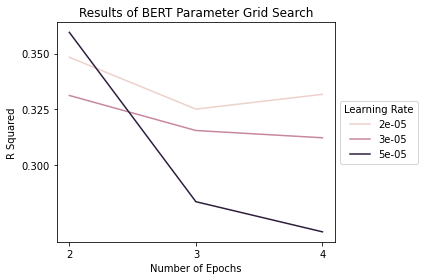

In [ ]:
bert_gs = pd.read_csv('/content/drive/MyDrive/data/icnale_bert_lexical/bert_gridsearch.csv')
ax = sns.lineplot(data=bert_gs, x='num_train_epochs', y='score', hue='learning_rate')
ax.set_title('Results of BERT Parameter Grid Search')
ax.set_ylabel('R Squared')
ax.set_xlabel('Number of Epochs')
# ax.set(ylim=(None, .35))
ax.set_yticks(np.linspace(.3, .35, num=3))
ax.set_xticks([2, 3, 4])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Learning Rate')
figure = ax.get_figure()
plt.tight_layout()
plt.show()   
figure.savefig('/content/drive/MyDrive/data/icnale_bert_lexical/figs/bert_gridsearch.png', dpi=300)

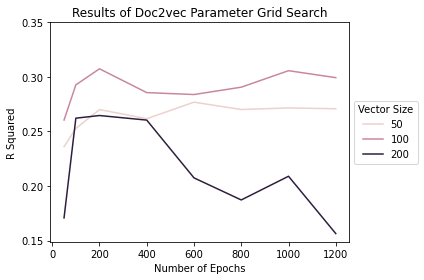

In [ ]:
d2v_gs = pd.read_csv('/content/drive/MyDrive/data/icnale_bert_lexical/d2v_gridsearch.csv')
ax = sns.lineplot(data=d2v_gs, x='epochs', y='score', hue='vector_size')
ax.set_title('Results of Doc2vec Parameter Grid Search')
ax.set_ylabel('R Squared')
ax.set_xlabel('Number of Epochs')
ax.set_yticks(np.linspace(.15, .35, num=5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Vector Size')
figure = ax.get_figure()
plt.tight_layout()
plt.show()   
figure.savefig('/content/drive/MyDrive/data/icnale_bert_lexical/figs/d2v_gridsearch.png', dpi=300)